# SVM Modeling
- Ignoring data before 2006.
- Using only type=5 examples.
- No feature selection.
- Param tuning.
- Added back removed features ['Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4']

In [1]:
import pandas as pd
import numpy as np
import os 

import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear

sns.set(style="whitegrid")

## Train and test datasets

Basic data containing palm tree information

In [9]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False)

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (3332, 7)
 Test: (4110, 6)
  All: (7442, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [22]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=6)
df_all_ftrs = addSoilFtrs(df_all_ftrs)
df_all_ftrs.columns

Index(['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month',
       'production', 'temperature', 'dewpoint',
       ...
       'SLTPPT_sl5', 'SLTPPT_sl6', 'SLTPPT_sl7', 'SNDPPT_sl1', 'SNDPPT_sl2',
       'SNDPPT_sl3', 'SNDPPT_sl4', 'SNDPPT_sl5', 'SNDPPT_sl6', 'SNDPPT_sl7'],
      dtype='object', length=113)

## Base Model 

Creation of a baseline model to finalize the competition submission pipeline. The idea is to create the most basic for future improvements.

In [11]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, make_scorer

# Exclude test data.
df_train = df_all_ftrs[~df_all_ftrs.production.isna()]

# Most important features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Validate
base_model = SVR(kernel='linear', C=1e-4)

# Validate using sliding window.
scores = cross_validate(base_model, Xt, y, scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2'}, 
                        cv=cvPerYear(X, y, 2009, 2012, evalOnlyLast=False), 
                        return_train_score=True)    

In [12]:
from pprint import pprint
for k in list(scores.keys()):
    scores['mean_' + k] = scores[k].mean()
pprint(scores)

{'fit_time': array([0.14046168, 0.22095561, 0.36412144]),
 'mean_fit_time': 0.24184624354044595,
 'mean_score_time': 0.12325906753540039,
 'mean_test_mae': -0.08815613809447542,
 'mean_test_r2': 0.33117717259058527,
 'mean_train_mae': -0.07618323314522597,
 'mean_train_r2': 0.34645939674984033,
 'score_time': array([0.14857554, 0.13784242, 0.08335924]),
 'test_mae': array([-0.08883867, -0.08470987, -0.09091987]),
 'test_r2': array([0.32607277, 0.32508338, 0.34237537]),
 'train_mae': array([-0.07546642, -0.07711736, -0.07596592]),
 'train_r2': array([0.32257808, 0.34230084, 0.37449927])}


### Grid Search

In [33]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

# Exclude test data.
df_train = df_all_ftrs[~df_all_ftrs.production.isna()]

# All features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Validate
base_model = SVR()

param_distros = {
    'C': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
#    'degree': [2, 3, 4, 5],
    'gamma': [0.001, 0.01, 0.1]
}

grid_search = RandomizedSearchCV(base_model, param_distros, n_iter=12,
                           scoring='neg_mean_absolute_error', 
                           n_jobs=3, iid=True, refit=False, 
                           cv=cvPerYear(X, y, 2009, 2012, evalOnlyLast=False),
                           return_train_score=True)

grid_search.fit(Xt, y)

res = pd.DataFrame(grid_search.cv_results_)

In [34]:
cols = [c for c in res.columns if 'train' in c]
cols.append('params')
res2 = res.drop(cols, axis=1)
#res2 = res2[res2.param_kernel == 'linear']
res2.sort_values('mean_test_score', ascending=False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,0.502126,0.195724,0.140175,0.038203,rbf,0.01,0.1,-0.087310,-0.081381,-0.090275,-0.085829,0.003315,1
6,0.832201,0.211563,0.267229,0.165493,rbf,0.001,0.1,-0.088596,-0.082447,-0.091391,-0.087013,0.003377,2
10,1.016568,0.293518,0.226150,0.074671,rbf,0.01,1,-0.085716,-0.085489,-0.099695,-0.087975,0.005248,3
4,0.528434,0.229451,0.137109,0.026534,rbf,0.01,0.01,-0.089917,-0.085609,-0.090869,-0.088640,0.002170,4
9,1.231762,0.712315,0.320553,0.197117,rbf,0.001,1,-0.092786,-0.086713,-0.094323,-0.091018,0.003093,5
3,0.832795,0.131213,0.172789,0.037847,rbf,0.001,0.01,-0.092825,-0.088820,-0.091475,-0.091265,0.001793,6
8,0.829661,0.419566,0.321448,0.128377,rbf,0.1,0.1,-0.101673,-0.095686,-0.099857,-0.099374,0.002686,7
1,0.590080,0.215308,0.165872,0.048680,rbf,0.01,0.001,-0.101179,-0.097651,-0.100899,-0.099956,0.001633,8
11,1.064157,0.037370,0.287980,0.136850,rbf,0.1,1,-0.102714,-0.097431,-0.104902,-0.101318,0.002856,9
0,0.643663,0.195174,0.185588,0.048385,rbf,0.001,0.001,-0.104253,-0.101540,-0.105020,-0.103477,0.001396,10


In [38]:
from sklearn.model_selection import validation_curve

# Param C range.
#param_range = np.logspace(-9, 0, 10, base=2)
param_range = np.logspace(-9, 0, 10, base=2)

# Cross-validation generator.
cv = cvPerYear(X, y, 2009, 2012, evalOnlyLast=False)

# Model.
model = SVR(kernel='rbf', C=0.1)

train_scores, test_scores = validation_curve(
    model, Xt, y, param_name='gamma', 
    param_range=param_range, cv=cv,
    scoring='neg_mean_absolute_error', n_jobs=3)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

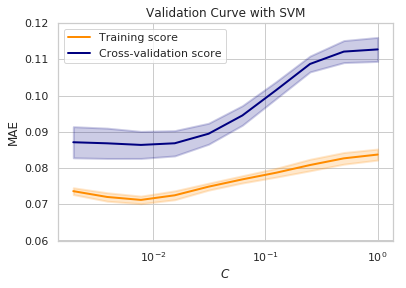

In [39]:
plt.title("Validation Curve with SVM")
plt.xlabel("$C$")
plt.ylabel("MAE")
plt.ylim(0.06, 0.12)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Train on all data

In [26]:
# Exclude test data.
df_train = df_all_ftrs[~df_all_ftrs.production.isna()]

# All features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Train.
base_model = SVR(kernel='rbf', C=1e-1)
base_model.fit(Xt, y)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Submission

It makes the predict of the basic model and creates the sample to substrate in kaggle, finishing the complete pipeline

In [28]:
# # Get test examples.
# df_test = df_all_ftrs[df_all_ftrs.production.isna()]

# # Important features.
# X = df_test[features]

# # Normalize input features.
# Xt = scaler.transform(X)

# # Make prediction.
# pred = base_model.predict(Xt)

# # Create a submission file.
# with open('../submissions/submission-all_data-ignore_lt2006-only_type5-no_ftr_selection-svr_rbf_C1e-1-added_back_soildftrs.csv', 'w') as f:
#     f.write("Id,production\n")
#     for _id, _pred in zip(df_test.Id.values, pred):
#         f.write("{},{}\n".format(_id, _pred))